In [1]:
# Turning on inline plots -- just for use in ipython notebooks.
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Initialization of a numerical experiment

Before running a drifter simulation, a number of parameters need to be specified. Previous examples of this are set in `init.py`. Because these examples change over time, we'll go through a specific example here.


In [6]:
# Normal Python libraries
import numpy as np
import netCDF4 as netCDF
import tracpy
import tracpy.plotting
from tracpy.tracpy_class import Tracpy
matplotlib.rcParams.update({'font.size': 20})

## Model output

Model output from a high resolution model of the Texas-Louisiana shelf for the years 2004-2012 is stored on a thredds server at the address in loc. This is freely accessible.

In [7]:
# Location of TXLA model output file and grid, on a thredds server.
loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_nesting6.nc'

## Time parameters

Model output is known to occur every four hours. The default test here will start at 00:00 on November 25, 2009 and run for 5 days.

In [15]:
# Number of days to run the drifters.
ndays = 3

# Start date in date time formatting
date = datetime.datetime(2009, 11, 25, 0)

# Time between outputs
tseas = 4*3600 # 4 hours between outputs, in seconds 

# Time units
time_units = 'seconds since 1970-01-01'

The TRACMASS algorithm updates the u and v flux fields using a linear combination of the previous and subsequent time step every time a drifter passes a grid cell wall, or when the time for the drifter has reached the time of the second model output time step. This maximum time allowed can be decreased using the `nsteps` parameter, which divides the time between model outputs into smaller pieces that then act as the maximum time the drifter can travel without the time fields being updated. The importance of this will depend on the grid size, velocity fields, and time between model outputs.

Separately, the user can choose how often to sample the drifter tracks. Since each drifter can experience a different number of steps, the `N` parameter is used to divide up the time between model output according to how often to have plot points for the drifters. `N` does not affect the drifter paths; it only controls the interval of sampling the drifter tracks. Linear interpolation is used to output drifter positions at the same times.

In [16]:
# Sets a smaller limit than between model outputs for when to force interpolation if hasn't already occurred.
nsteps = 5
# Controls the sampling frequency of the drifter tracks.
N = 4

After initialization, drifters can be stepped forward or backward in time. Running backward in time essentially means that we change the sign of the velocity fields and step backward in the model output files (in which case we set `ff=-1`). We'll move forward in time (`ff=1`).

In [17]:
# Use ff = 1 for forward in time and ff = -1 for backward in time.
ff = 1

## Subgrid parameterization parameters

An integer flag is used to control whether or not to use subgrid parameterization in the particle tracking, and if so, which kind.

Options are:

* `doturb=0` uses no sub grid parameterization and thus the drifters are passively advected according strictly to the output velocity fields
* `doturb=1` adds to the current velocity fluxes parameterized turbulent velocity fluxes of the order of the current velocity fluxes
* `doturb=2` adds to the calculated new drifter location a slightly displaced drifter location that is randomly placed based on a circle around the drifter location
* `doturb=3` adds to the calculated new drifter location a slightly displaced drifter location that is randomly placed based on an ellipse of the bathymetry around the drifter location

The horizontal and vertical diffusivities are set by the user. These values may or may not be used in the experiment depending on whether a subgrid parameterization is used, and, if so, which is used. The horizontal diffusivity value is used by all of the horizontal subgrid parameterizations. The vertical diffusivity is not used in the two-dimensional case. Since this experiment is not using either diffusivity values, they will be set to zero to avoid confusion.

Appropriate values to use for this are currently being investigated using sensitivity studies on the Texas-Louisiana shelf. Some values have been used and compared in studies, and values can be calculated from physical drifters for a specific domain. This is on-going work! In a sensitivity study, a smaller value, like `ah=5`, leads to somewhat diffused results that are still very close to the non-diffusive case. A larger value of `ah=20` led to more diffused results that were still quite similar to the non-diffusive case.

In [18]:
ah = 0. # m^2/s
av = 0. # m^2/s

# turbulence/diffusion flag
doturb = 0

## File saving

The input `name` will be used for saving the particle tracks into a netCDF file and for the figures.

In [19]:
# simulation name, used for saving results into netcdf file
name = 'temp'

### Vertical

There are a number of options for the initial vertical placement of the drifters. The behavior is controlled by the combination of `z0` and `zpar`, and `do3d` must be set accordingly as well.

The `do3d` flag controls whether or not drifters are allowed to move vertically or not:

* `do3d=0` for two-dimensional particle tracking
* `do3d=1` for three-dimensional particle tracking

For 3D tracking, set `do3d=1` and `z0` should be an array of initial drifter depths. The array should be the same size as `lon0` and negative for under water. Currently, drifter depths need to be above the seabed for every (x, y) particle location for the script to run.

To do 3D but start at surface, use `z0 = zeros(lon0.shape)` and have either `zpar='fromMSL'` so that `z0` starting depths represent that depth below the base, time-independent sea level (or mean sea level) or choose `zpar='fromZeta'` to have `z0` starting depths represent that depth below the time-dependent sea surface. Currently only the `zpar='fromZeta'` case is coded up.

For 2D drifter movement, set `do3d=0`. Then there are the following options:

* set z0 to 's' for 2D along a terrain-following slice and zpar to be the index of s level you want to use (0 to km-1)
* set z0 to 'rho' for 2D along a density surface and zpar to be the density value you want to use. Can do the same thing with salinity ('salt') or temperature ('temp'). The model output doesn't currently have density.
* set z0 to 'z' for 2D along a depth slice and zpar to be the constant (negative) depth value you want to use
* To simulate drifters at the surface, set z0 to 's' and zpar = grid['km']-1 (whatever that value is) to put them in the upper s level. This is probably the most common option.

In [20]:
# for 3d flag, do3d=0 makes the run 2d and do3d=1 makes the run 3d
do3d = 0

## Choose method for vertical placement of drifters
z0 = 's' # I know the size from checking #'s after eliminating those outside domain ' #'z' #'salt' #'s' 
num_layers = 30
zpar = num_layers-1 # 29 #-10 #grid['km']-1 # 30 #grid['km']-1

# #### 3D Sample Options ####
# # for 3d flag, do3d=0 makes the run 2d and do3d=1 makes the run 3d
# do3d = 1

# ## Choose method for vertical placement of drifters
# z0 = np.zeros(676) # I know the size from checking #'s after eliminating those outside domain ' #'z' #'salt' #'s' 
# num_layers = 30
# zpar = 'fromZeta' #num_layers-1 # 29 #-10 #grid['km']-1 # 30 #grid['km']-1
# ####

### Initialize a projection

In newer versions of `TracPy` (after 0.01), projection information has been separated from the grid information. So, you first set up a project, then use this to set up your grid. The function call is:

> tracpy.tools.make_proj(setup='nwgom', usebasemap=True, **kwargs)

where the keyword arguments include lat/lon inputs for the projection bounds, and there are several built in projections for convenience which can be altered:

* 'nwgom' - for NW Gulf of Mexico, for use with basemap
* 'galveston' - for Galveston Bay, for use with pyproj
* 'nwgom-pyproj' - for NW Gulf of Mexico, for use without basemap


In [21]:
proj = tracpy.tools.make_proj('nwgom-pyproj')

## Initialize TracPy class

In [22]:
# Read in grid
grid = tracpy.inout.readgrid(loc, proj, usespherical=True)

# Initialize Tracpy class
tp = Tracpy(loc, grid, name=name, tseas=tseas, ndays=ndays, nsteps=nsteps,
            N=N, ff=ff, ah=ah, av=av, doturb=doturb, do3d=do3d, z0=z0, zpar=zpar, time_units=time_units)

## Drifter initialization

### Horizontal

Drifters are seeded by the latitude and longitude. A simple way to do this is to set up a mesh of points within a lat/lon box. In this case, we are looking at drifters starting throughout the TX-LA shelf domain. For the `linspace` function, we can play around with the number of points to control approximately how far apart the drifters begin. For this example, the number of points are about 20 km apart. 

After initializing these points, we can run them through a check script to eliminate points outside the domain (without this step, points outside the numerical domain will cause an error).

In [27]:
# Input starting locations as real space lon,lat locations
lon0, lat0 = np.meshgrid(np.linspace(-98.5,-87.5,55), \
                            np.linspace(22.5,31,49)) # whole domain, 20 km

# Eliminate points that are outside domain or in masked areas
lon0, lat0 = tracpy.tools.check_points(lon0, lat0, tp.grid)

-- / 2695  drifters NaN-ed out.


# Run the numerical experiment

In [26]:
# Note in timing that the grid was already read in
lonp, latp, zp, t, T0, U, V = tracpy.run.run(tp, date, lon0, lat0)

/Users/mollykerwick/Documents/projects/tracpy/tracpy/inout.py:75: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  istart = find(dates <= date)[-1]


Using GCM model output index  0
Using GCM model output index  1
Using GCM model output index  2
Using GCM model output index  3
Using GCM model output index  4
Using GCM model output index  5
Using GCM model output index  6
Using GCM model output index  7
Using GCM model output index  8
Using GCM model output index  9
Using GCM model output index  10
Using GCM model output index  11
Using GCM model output index  12
Using GCM model output index  13
Using GCM model output index  14
Using GCM model output index  15
Using GCM model output index  16
Using GCM model output index  17

Simulation name:  temp

Total run time: 22.570235 (seconds)
---------------------------------------------
Time spent on:
	1: Preparing for simulation    		1.7576 (7.7871%)
	2: Preparing for model step    		20.4279 (90.5082%)
	3: Stepping, using TRACMASS    		0.0635 (0.2812%)
	4: Processing after model step 		0.0059 (0.0263%)
	5: Processing after simulation 		0.3153 (1.3971%)


# Plotting the results

Plots generated below by the user can be compared with those available in `tracpy/docs/figures`.

## Plot tracks

/Users/mollykerwick/Documents/projects/tracpy/tracpy/tools.py:210: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  xpc.append(xp[idrift, find(ind3)[ind]])
/Users/mollykerwick/Documents/projects/tracpy/tracpy/tools.py:211: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  ypc.append(yp[idrift, find(ind3)[ind]])
/Users/mollykerwick/Documents/projects/tracpy/tracpy/tools.py:214: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  xpc.append(xp[idrift, find(ind3)[ind]])
/Users/mollykerwick/Documents/projects/tracpy/tracpy/tools.py:215: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  ypc.append(yp[idrift, find(ind3)[ind]])
/Users/mollykerwick/miniconda3/envs/tabs/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarn

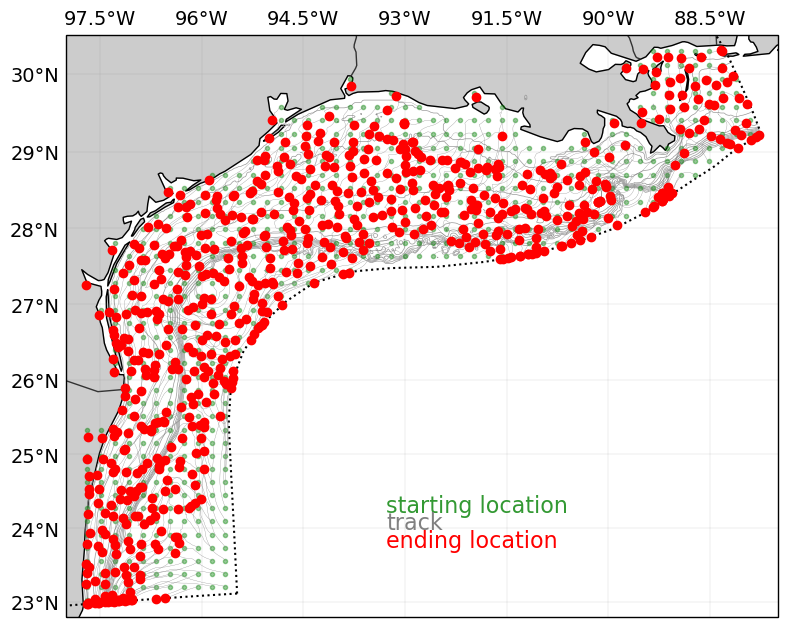

In [25]:
fig = plt.figure(figsize=(9.4, 7.7), dpi=100)
ax = tracpy.plotting.background(grid, fig=fig, extent=[-98, -87.5, 22.8, 30.5],
               col='lightgrey', halpha=1, outline=[1, 1, 0, 1], res='50m')
tracpy.plotting.tracks(lonp, latp, tp.name, grid, fig=fig, ax=ax)